In [8]:
%pip install torch
%pip install torchvision

     ---------------------------------------- 1.1/1.1 MB 5.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [98]:
%pip install --upgrade numpy

     ---------------------------------------- 14.8/14.8 MB 3.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'C:\\Users\\pierr\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\~umpy\\.libs\\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from PIL import Image
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from skimage import io
import os

c:\Users\pierr\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pathToCategories = "./baseline/baseline/"
# labels=["highway", "office", "pedestrians", "PETS2006"]
# fonction d'acquisition des donnees dentrees et de validation pour l'analyse par rapport a une categories de video mis en parametre
def init_dataset(labels):
    input_data = {}
    groundTruth_data = {}
    nb_image = {}
    i=0
    for label in labels:
        input_data[label] = [str(p) for p in Path(
            pathToCategories+label+"/input/").glob('*.jpg')]
        groundTruth_data[label] = [str(p) for p in Path(
            pathToCategories+label+"/groundtruth/").glob('*.png')]
        nb_image[label] = len(input_data[label])
    return nb_image,input_data,groundTruth_data


In [31]:
input_data,groundTruth_data=init_dataset(labels,4)

TypeError: init_dataset() takes 1 positional argument but 2 were given

### Segmentation sémantique

In [3]:
#fonction appliquant des pretransformation aux cathegories dimage recu et retournant la liste des images retransforme en Tensor

preprocessing = transforms.Compose([
    transforms.ToTensor(),
])
# def get_input_tensor(labels,input_data):
#     input_tensor_label = {}
#     for label in labels:
#         input_tensor_label[label] = []
#         for input in input_data[label]:
#             tensor = preprocessing(Image.fromarray(io.imread(input)))#io.imread(os.path.join(input)) )
#             #tensor = preprocessing(cv2.imread("./"+input))
#             input_tensor_label[label].append(tensor)
#     return input_tensor_label
def get_input_tensor(input_data):
    input_tensor_label = {}
    input_tensor_label = []
    for input in input_data:
        tensor = preprocessing(Image.fromarray(io.imread(input)))#io.imread(os.path.join(input)) )
            #tensor = preprocessing(cv2.imread("./"+input))
        input_tensor_label.append(tensor)
    return input_tensor_label

In [26]:
input_tensor_label=get_input_tensor(labels,input_data)

KeyboardInterrupt: 

In [45]:
# return images in batch for prediction analysist
#def stack_input_tensor(labels,input_tensor_label):
    #input_batch_tensor_label = {}
    #for label in labels:
        #input_batch_tensor_label[label] =[]
        #for tensor in input_tensor_label[label]:
        #input_batch_tensor_label[label]=torch.stack(input_tensor_label[label], 0)
        #input_batch_tensor_label=torch.stack(input_tensor_label, 0)
        #input_batch_tensor_label[label] = input_batch_tensor_label[label].cuda() 
    #return input_batch_tensor_label

def stack_input_tensor(input_tensor_label):
    input_batch_tensor_label=torch.stack(input_tensor_label, 0)
    return input_batch_tensor_label


In [47]:
def evaluate(input_batch_tensor_label):
    model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
    predictions = {}
    with torch.no_grad():
        predictions = model(input_batch_tensor_label)
    return predictions

In [78]:
def draw_segmentation_mask(image):
  name_colors=list(mcolors.CSS4_COLORS.keys())[7:7+2]
  rgb_colors=np.array([(np.array(mcolors.to_rgb(i))*255).astype("uint8") for i in name_colors])
  image.putpalette(rgb_colors)
  return image

#### Fonction Main de lexecution pour obtenir la segmentation sementique

In [82]:
labels = ["highway"]# "office", "pedestrians", "PETS2006"]
batchSize = 4
print("initialising dataset: ",labels," with batchSize = ",batchSize)
nb_image, input_data, true_data = init_dataset(labels)
mini_input_data={}
for label in labels:
    print("current label :",label)
    current = 0
    anounce_ID =250
    while(current < nb_image[label]):
        if current > anounce_ID:
            print("are now at", anounce_ID)
            anounce_ID +=250
        if (current+batchSize) > nb_image[label]:
            mini_input_data[label]=input_data[label][current:-1]
            current = nb_image[label]
        else:
            mini_input_data[label]=input_data[label][current:(current+batchSize)]
            current += batchSize

        input_tensor_label = get_input_tensor(mini_input_data[label])
        input_batch_tensor_label = stack_input_tensor(input_tensor_label)
        predictions = evaluate(input_batch_tensor_label)
        for i in range(len(mini_input_data[label])):
            prediction = torch.argmax(predictions['out'][i].squeeze(), dim=0).detach().cpu().numpy().astype(np.uint8)
            masks = Image.fromarray(prediction)
            segmentation_mask=draw_segmentation_mask(masks)
            segmentation_mask.save(mini_input_data[label][i].replace("input","output_sem_seg"),format="PNG")



initialising dataset:  ['highway']  with batchSize =  4
current label : highway
are now at 250
are now at 500
are now at 750
are now at 1000
are now at 1250
are now at 1500


### Soustraction d'arrière-plan

In [3]:
from random import randrange
def initBackground(frame):
    """
    deprecated
    """
    frame_size=np.shape(frame)
    background=np.empty((frame_size[0],frame_size[1],20))
    for i in range(frame_size[0]):
        for j in range(frame_size[1]):
            if i<frame_size[0]-1 and j<frame_size[1]-1:
                if i>=1 and j>=1:
                    neighbours=frame[i-1:i+2,j-1:j+2]
                    print(np.shape(neighbours))
                    neighbours_pixel=np.delete(neighbours,(12,13,14))
                    for k in range(20):
                        neigh_pixel_index=randrange(8*3)
                        background[i,j,k]=neighbours_pixel[neigh_pixel_index]
                        
                elif i>=1:
                    neighbours=frame[i-1:i+2,j:j+2]
                    neighbours_pixel=np.delete(neighbours,(6,7,8))
                    for k in range(20):
                        neigh_pixel_index=randrange(5*3)
                        background[i,j,k]=neighbours_pixel[neigh_pixel_index]
                elif j>=1:
                    neighbours=frame[i:i+2,j-1:j+2]
                    neighbours_pixel=np.delete(neighbours,(3,4,5))
                    for k in range(20):
                        neigh_pixel_index=randrange(5*3)
                        background[i,j,k]=neighbours_pixel[neigh_pixel_index]
                else:
                    neighbours=frame[i:i+2,j:j+2]
                    neighbours_pixel=np.delete(neighbours,(0,1,2))
                    for k in range(20):
                        neigh_pixel_index=randrange(3*3)
                        background[i,j,k]=neighbours_pixel[neigh_pixel_index]
            elif i<frame_size[0]-1:
                if i>=1:
                    neighbours=frame[i-1:i+2,j-1:j+1]
                    neighbours_pixel=np.delete(neighbours,(9,10,11))
                    for k in range(20):
                        neigh_pixel_index=randrange(5*3)
                        background[i,j,k]=neighbours_pixel[neigh_pixel_index]
                else:
                    neighbours=frame[i:i+2,j-1:j+1]
                    neighbours_pixel=np.delete(neighbours,(9,10,11))
                    for k in range(20):
                        neigh_pixel_index=randrange(3*3)
                        background[i,j,k]=neighbours_pixel[neigh_pixel_index]
            elif j<frame_size[1]-1:
                if j>=1:
                    neighbours=frame[i-1:i+1,j-1:j+2]
                    neighbours_pixel=np.delete(neighbours,(12,13,14))
                    for k in range(20):
                        neigh_pixel_index=randrange(5*3)
                        background[i,j,k]=neighbours_pixel[neigh_pixel_index]
                else:
                    neighbours=frame[i-1:i+1,j:j+2]
                    neighbours_pixel=np.delete(neighbours,(6,7,8))
                    for k in range(20):
                        neigh_pixel_index=randrange(3*3)
                        background[i,j,k]=neighbours_pixel[neigh_pixel_index]
            else:
                neighbours=frame[i-1:i+1,j-1:j+1]
                neighbours_pixel=np.delete(neighbours,(9,10,11))
                for k in range(20):
                    neigh_pixel_index=randrange(3*3)
                    background[i,j,k]=neighbours_pixel[neigh_pixel_index]

    return background      




In [3]:
from random import randrange
import random
def initBackground(frame,nb_samples,gray_scale=False):
    frame_size=np.shape(frame)
    if gray_scale:
        background=np.empty((frame_size[0],frame_size[1],nb_samples))    
    else:
        background=np.empty((frame_size[0],frame_size[1],nb_samples,3))
    
    for i in range(frame_size[0]):
        for j in range(frame_size[1]):
            if i<frame_size[0]-1 and j<frame_size[1]-1:
                if i>=1 and j>=1:
                    neighbours=frame[i-1:i+2,j-1:j+2]
                    
                    
                    #neighbours_pixel=np.delete(neighbours,(12,13,14))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])
                        #neigh_pixel_index=randrange(np.shape(neighbours)[0]*np.shape(neighbours)[1]-1)
                        #background[i,j,k,0]=neighbours_pixel[neigh_pixel_index*3]
                        #background[i,j,k,1]=neighbours_pixel[neigh_pixel_index*3+1]
                        #background[i,j,k,2]=neighbours_pixel[neigh_pixel_index*3+2]
                        background[i,j,k]=frame[i_n,j_n]
                        
                elif i>=1:
                    neighbours=frame[i-1:i+2,j:j+2]
                    #neighbours_pixel=np.delete(neighbours,(6,7,8))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
                elif j>=1:
                    neighbours=frame[i:i+2,j-1:j+2]
                    #neighbours_pixel=np.delete(neighbours,(3,4,5))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i, j-1],             [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
                else:
                    neighbours=frame[i:i+2,j:j+2]
                    #neighbours_pixel=np.delete(neighbours,(0,1,2))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([          [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
            elif i<frame_size[0]-1:
                if i>=1:
                    neighbours=frame[i-1:i+2,j-1:j+1]
                    #neighbours_pixel=np.delete(neighbours,(9,10,11))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                                  [i, j-1],
                                                  [i+1, j-1], [i+1, j],])
                        background[i,j,k]=frame[i_n,j_n]
                else:
                    neighbours=frame[i:i+2,j-1:j+1]
                    #neighbours_pixel=np.delete(neighbours,(9,10,11))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i, j-1], 
                                                  [i+1, j-1], [i+1, j]])
                        background[i,j,k]=frame[i_n,j_n]
            elif j<frame_size[1]-1:
                if j>=1:
                    neighbours=frame[i-1:i+1,j-1:j+2]
                    #neighbours_pixel=np.delete(neighbours,(12,13,14))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
                else:
                    neighbours=frame[i-1:i+1,j:j+2]
                    #neighbours_pixel=np.delete(neighbours,(6,7,8))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
            else:
                neighbours=frame[i-1:i+1,j-1:j+1]
                #neighbours_pixel=np.delete(neighbours,(9,10,11))
                for k in range(nb_samples):
                    i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                              [i, j-1]             ])
                    background[i,j,k]=frame[i_n,j_n]

    return background      




In [4]:
import random
def updateBackground(background, frame):
    frame_size = np.shape(frame)
    for i in range(frame_size[0]):
        for j in range(frame_size[1]):
            update = randrange(16)
            if update == 15:
                sample = randrange(20)
                if i < frame_size[0]-1 and j < frame_size[1]-1:
                    if i >= 1 and j >= 1:
                        #neighbours = frame[i-1:i+2, j-1:j+2]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1], [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])

                        #i_padding = randrange(-1, 2)
                        #i_padding += i_padding >= 0
                        #j_padding = randrange(-1, 2)
                        #j_padding += j_padding >= 0 and i_padding >= 0

                    elif i >= 1:
                        neighbours = frame[i-1:i+2, j:j+2]
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                  [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
                        """
                        i_padding = randrange(-1, 2)
                        i_padding += i_padding >= 0
                        j_padding = randrange(2)
                        j_padding += j_padding >= 0
                        background[i, j, sample,
                                   0] = frame[i+i_padding, j+j_padding][0]
                        background[i, j, sample,
                                   1] = frame[i+i_padding, j+j_padding][1]
                        background[i, j, sample,
                                   2] = frame[i+i_padding, j+j_padding][2]
                        """
                    elif j >= 1:
                        neighbours = frame[i:i+2, j-1:j+2]
                        i_n, j_n = random.choice([[i, j-1], [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])
                        """
                        i_padding = randrange(2)
                        i_padding += i_padding >= 0
                        j_padding = randrange(-1, 2)
                        j_padding += j_padding >= 0
                        background[i, j, sample,
                                   0] = frame[i+i_padding, j+j_padding][0]
                        background[i, j, sample,
                                   1] = frame[i+i_padding, j+j_padding][1]
                        background[i, j, sample,
                                   2] = frame[i+i_padding, j+j_padding][2]
                        """
                    else:
                        neighbours = frame[i:i+2, j:j+2]
                        i_n, j_n = random.choice([            [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
                        """
                        i_padding = randrange(2)
                        i_padding += i_padding >= 0
                        j_padding = randrange(2)
                        j_padding += j_padding >= 0
                        background[i, j, sample,
                                   0] = frame[i+i_padding, j+j_padding][0]
                        background[i, j, sample,
                                   1] = frame[i+i_padding, j+j_padding][1]
                        background[i, j, sample,
                                   2] = frame[i+i_padding, j+j_padding][2]
                        """
                elif i < frame_size[0]-1:
                    if i >= 1:
                        neighbours = frame[i-1:i+2, j-1:j+1]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                                  [i, j-1],
                                                  [i+1, j-1], [i+1, j]])
                        """
                        i_padding = randrange(-1, 2)
                        i_padding += i_padding >= 0
                        j_padding = randrange(-1, 1)
                        j_padding += j_padding >= 0
                        background[i, j, sample,
                                   0] = frame[i+i_padding, j+j_padding][0]
                        background[i, j, sample,
                                   1] = frame[i+i_padding, j+j_padding][1]
                        background[i, j, sample,
                                   2] = frame[i+i_padding, j+j_padding][2]
                        """
                    else:
                        neighbours = frame[i:i+2, j-1:j+1]
                        i_n, j_n = random.choice([[i, j-1],
                                                  [i+1, j-1], [i+1, j]])
                        """
                        i_padding = randrange(2)
                        i_padding += i_padding >= 0
                        j_padding = randrange(-1, 1)
                        j_padding += j_padding >= 0
                        background[i, j, sample,
                                   0] = frame[i+i_padding, j+j_padding][0]
                        background[i, j, sample,
                                   1] = frame[i+i_padding, j+j_padding][1]
                        background[i, j, sample,
                                   2] = frame[i+i_padding, j+j_padding][2]
                        """
                elif j < frame_size[1]-1:
                    if j >= 1:
                        neighbours = frame[i-1:i+1, j-1:j+2]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1]])
                        """
                        i_padding = randrange(-1, 1)
                        i_padding += i_padding >= 0
                        j_padding = randrange(-1, 2)
                        j_padding += j_padding >= 0
                        background[i, j, sample,
                                   0] = frame[i+i_padding, j+j_padding][0]
                        background[i, j, sample,
                                   1] = frame[i+i_padding, j+j_padding][1]
                        background[i, j, sample,
                                   2] = frame[i+i_padding, j+j_padding][2]
                        """
                    else:
                        neighbours = frame[i-1:i+1, j:j+2]
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1]])
                        """
                        i_padding = randrange(-1, 1)
                        i_padding += i_padding >= 0
                        j_padding = randrange(2)
                        j_padding += j_padding >= 0
                        background[i, j, sample,
                                   0] = frame[i+i_padding, j+j_padding][0]
                        background[i, j, sample,
                                   1] = frame[i+i_padding, j+j_padding][1]
                        background[i, j, sample,
                                   2] = frame[i+i_padding, j+j_padding][2]
                        """
                else:
                    neighbours = frame[i-1:i+1, j-1:j+1]
                    i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                              [i, j-1]             ])
                    """
                    i_padding = randrange(-1, 1)
                    i_padding += i_padding >= 0
                    j_padding = randrange(-1, 1)
                    j_padding += j_padding >= 0
                    background[i, j, sample,
                               0] = frame[i+i_padding, j+j_padding][0]
                    background[i, j, sample,
                               1] = frame[i+i_padding, j+j_padding][1]
                    background[i, j, sample,
                               2] = frame[i+i_padding, j+j_padding][2]
                    """
                background[i, j, sample,
                                   0] = frame[i_n, j_n][0]
                background[i, j, sample,
                            1] = frame[i_n, j_n][1]
                background[i, j, sample,
                            2] = frame[i_n, j_n][2]
                updateNeighbour(i_n, j_n,
                                i, j, background, frame)


In [27]:
import random
i=2
j=19
i_n, j_n = random.choice([[i, j-1], [i, j+1],[i+1, j-1], [i+1, j], [i+1, j+1]])
print(i_n,j_n)

3 20


In [4]:
def updateNeighbour(X_n,Y_n,X,Y,background,frame,nb_samples):
    k=randrange(nb_samples)
    background[X_n,Y_n,k]=frame[X,Y]
    

In [5]:
labels=["highway", "office", "pedestrians", "PETS2006"]
nb_images,input_data,groundTruth_data=init_dataset(labels)

In [6]:
def segmentationViBe(frame,background_model,R,seuil):
    frame_shape=np.shape(frame)
    res=np.empty((frame_shape[0],frame_shape[1]))
    R2=R**2
    for i in range(frame_shape[0]):
        for j in range(frame_shape[1]):
            center=frame[i,j]
            #print(center)
            count=0
            #print("xample")
            for sample in background_model[i,j]:
                #print(sample)
                dist_with_center=(np.linalg.norm(center-sample))**2
                if dist_with_center<R2:
                    count+=1
            if count>=seuil:
                res[i,j]=0
            else:
                res[i,j]=255
    return res


In [ ]:
import cv2
img=io.imread(input_data["PETS2006"][0])
#img=cv2.resize(img,(200,100))
background=initBackground(img)
for input in input_data["PETS2006"][1:20]:
    img=io.imread(input)
    #img=cv2.resize(img,(200,100))
    updateBackground(background,img)
    res=segmentationViBe(img,background,20,2)
    plt.imshow(img)
    plt.show()
    plt.imshow(res,cmap='gray', vmin=0, vmax=255)
    plt.show()


In [7]:
def segmentationViBe2(frame,background_model,R,seuil,nb_samples):
    frame_size=np.shape(frame)
    res=np.empty((frame_size[0],frame_size[1]))
    R2=R**2
    for i in range(frame_size[0]):
        for j in range(frame_size[1]):
            center=frame[i,j]
            count=0
            #print("xample")
            for sample in background_model[i,j]:
                dist_with_center=(np.linalg.norm(center-sample))**2
                if dist_with_center<R2:
                    count+=1
            if count>=seuil:
                res[i,j]=0
            else:
                res[i,j]=255

            #update background    
            update = randrange(16)
            if update == 15:
                sample = randrange(nb_samples)
                if i < frame_size[0]-1 and j < frame_size[1]-1:
                    if i >= 1 and j >= 1:
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1], [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])

                    elif i >= 1:
                        neighbours = frame[i-1:i+2, j:j+2]
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                  [i, j+1],
                                                  [i+1, j], [i+1, j+1]])

                    elif j >= 1:
                        neighbours = frame[i:i+2, j-1:j+2]
                        i_n, j_n = random.choice([[i, j-1], [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])

                    else:
                        neighbours = frame[i:i+2, j:j+2]
                        i_n, j_n = random.choice([            [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
               
                elif i < frame_size[0]-1:
                    if i >= 1:
                        neighbours = frame[i-1:i+2, j-1:j+1]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                                  [i, j-1],
                                                  [i+1, j-1], [i+1, j]])
                    
                    else:
                        neighbours = frame[i:i+2, j-1:j+1]
                        i_n, j_n = random.choice([[i, j-1],
                                                  [i+1, j-1], [i+1, j]])
                        
                elif j < frame_size[1]-1:
                    if j >= 1:
                        neighbours = frame[i-1:i+1, j-1:j+2]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1]])
                        
                    else:
                        neighbours = frame[i-1:i+1, j:j+2]
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1]])
                        
                else:
                    neighbours = frame[i-1:i+1, j-1:j+1]
                    i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                              [i, j-1]             ])

                """    
                background[i, j, sample,
                                   0] = frame[i_n, j_n][0]
                background[i, j, sample,
                            1] = frame[i_n, j_n][1]
                background[i, j, sample,
                            2] = frame[i_n, j_n][2]
                """
                background[i, j, sample] = frame[i_n, j_n]
                updateNeighbour(i_n, j_n,
                                i, j, background, frame,nb_samples)
    return res


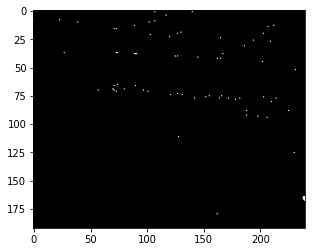

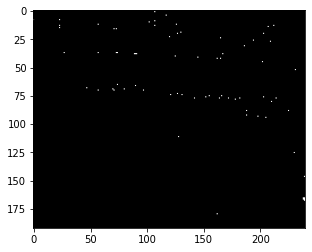

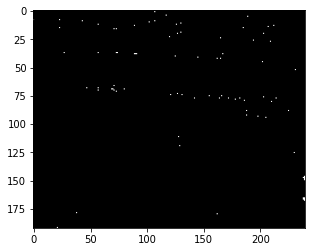

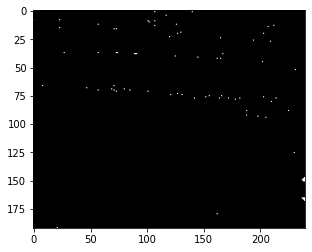

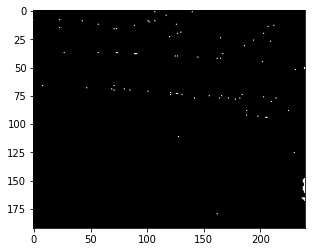

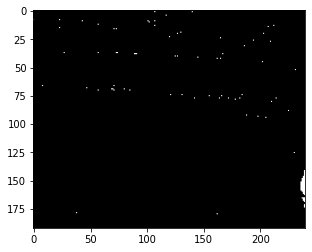

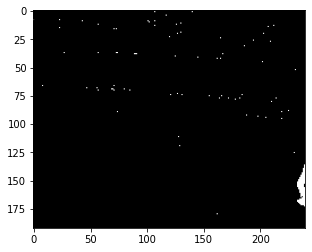

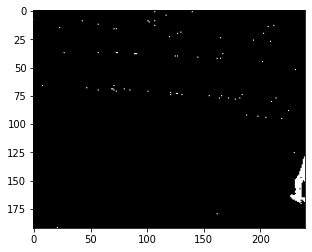

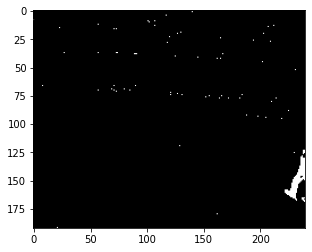

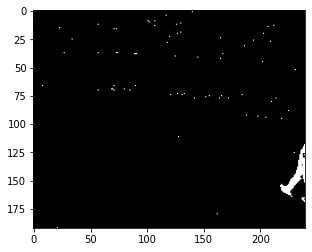

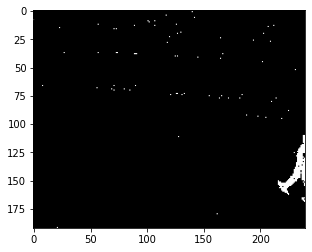

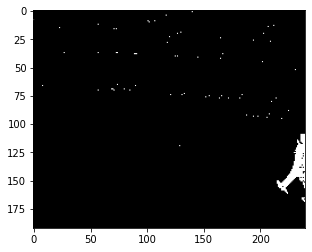

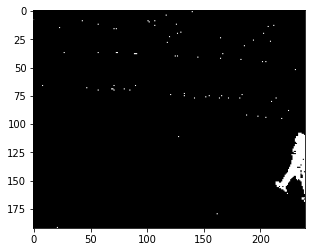

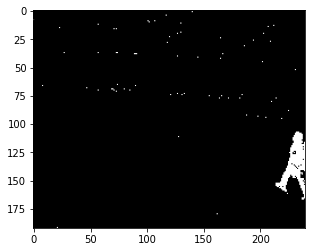

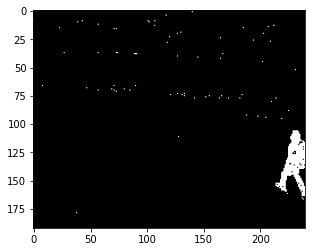

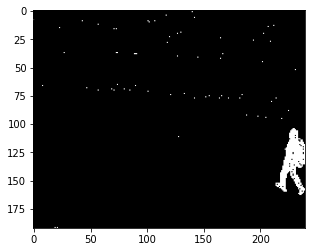

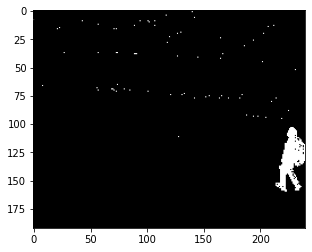

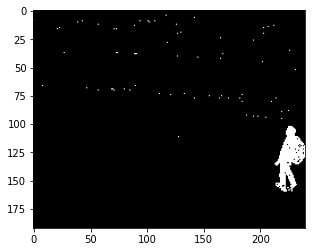

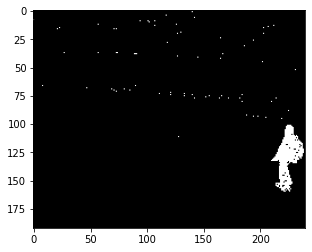

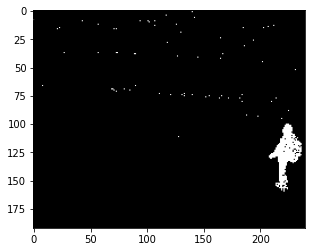

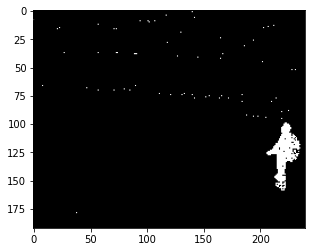

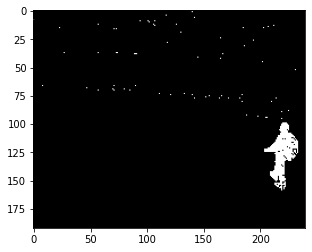

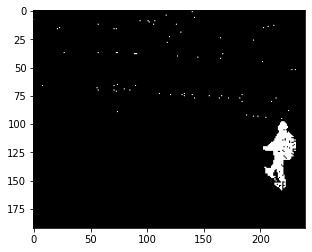

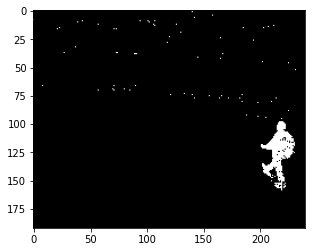

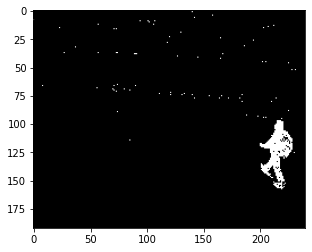

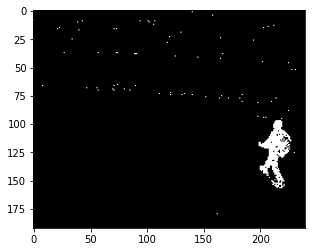

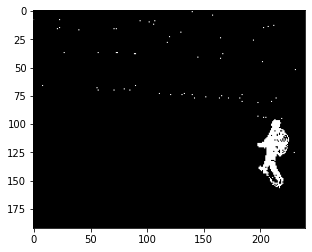

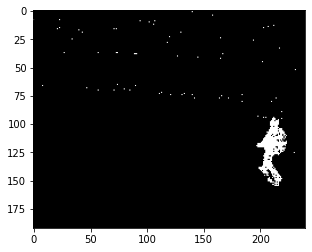

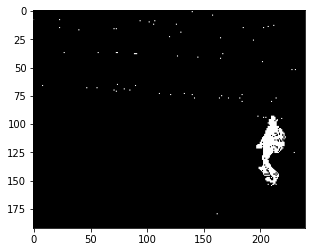

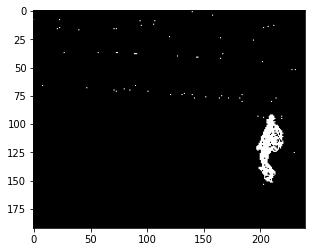

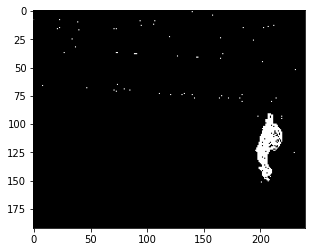

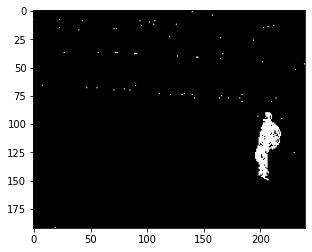

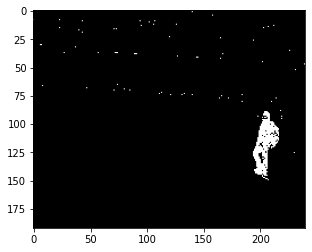

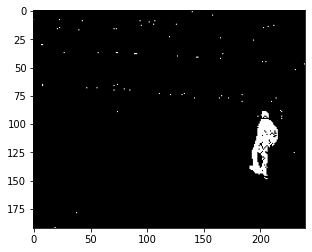

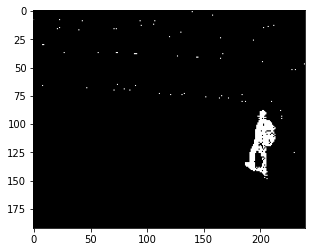

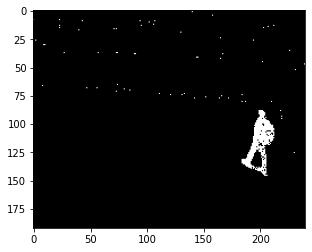

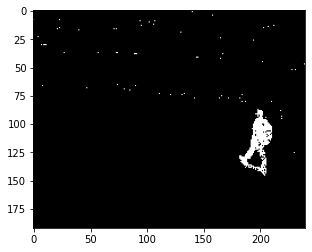

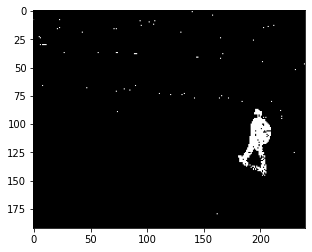

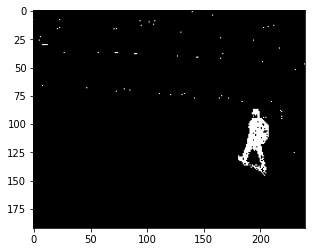

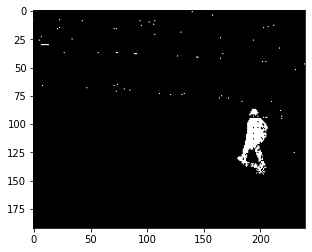

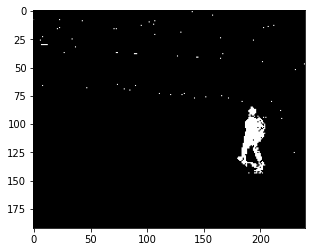

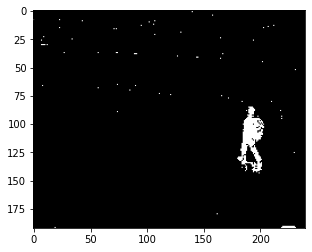

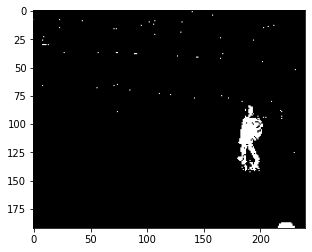

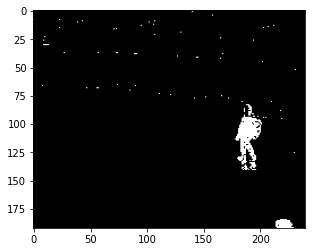

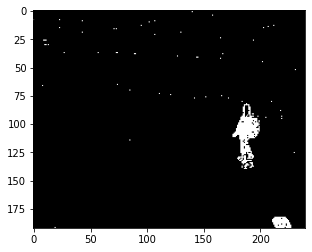

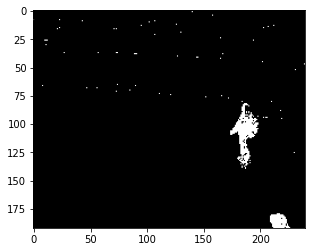

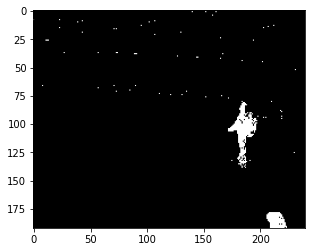

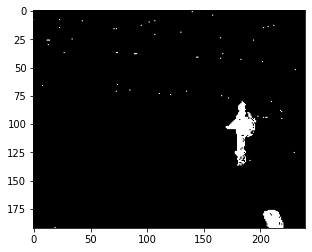

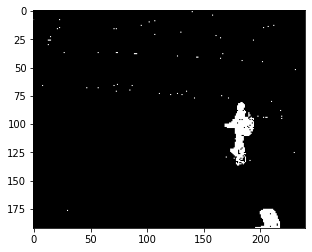

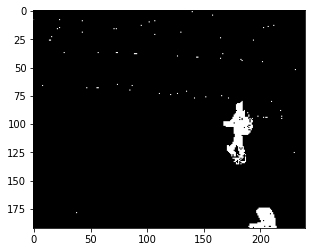

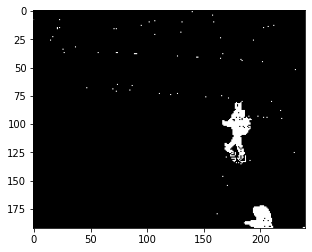

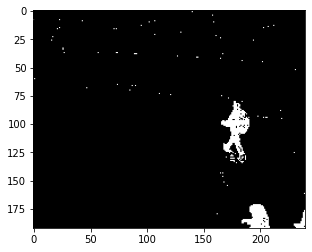

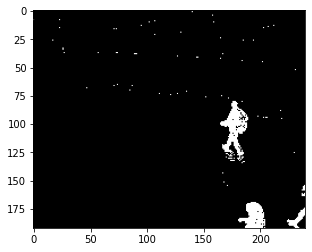

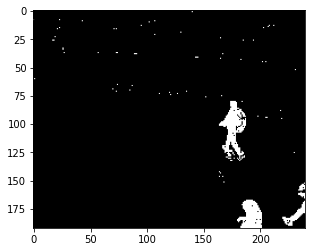

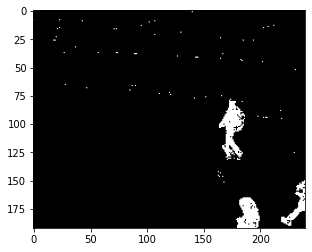

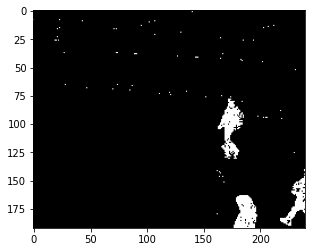

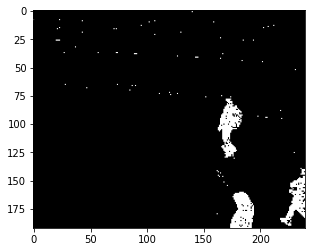

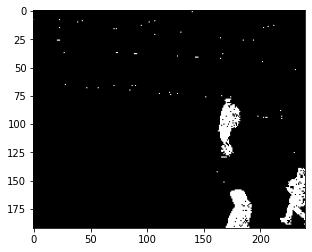

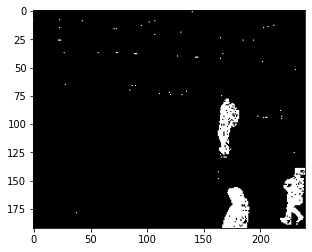

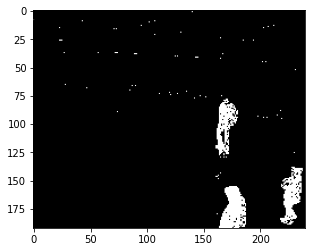

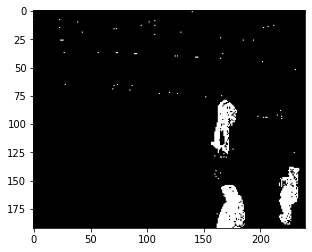

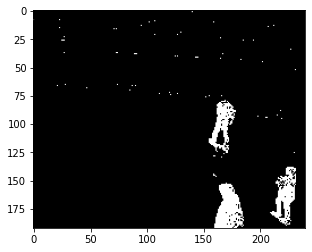

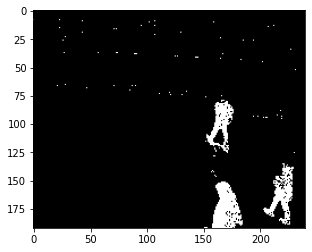

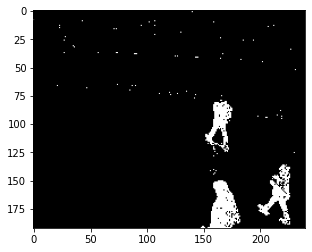

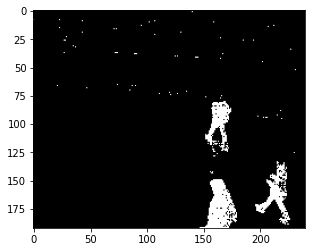

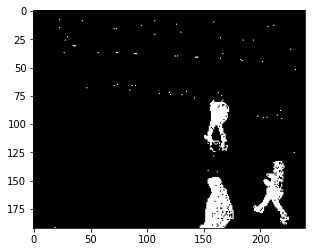

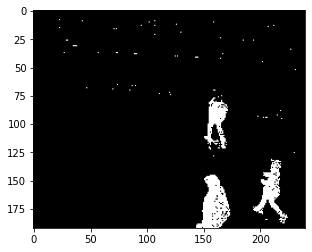

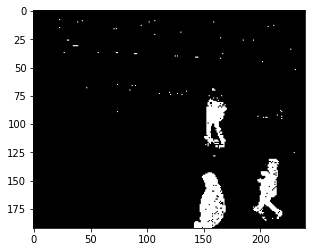

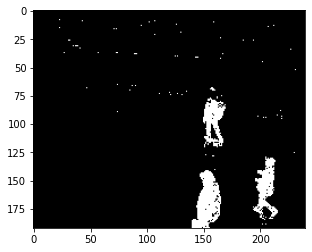

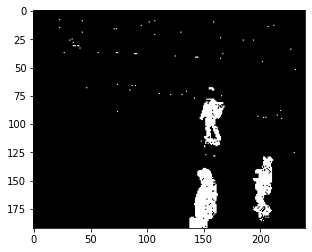

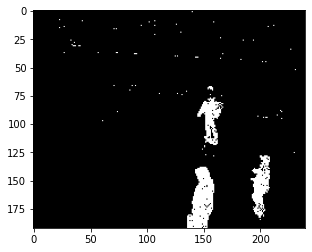

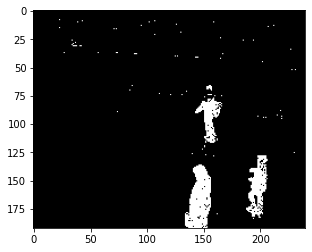

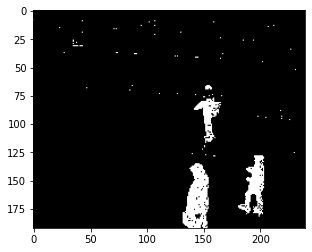

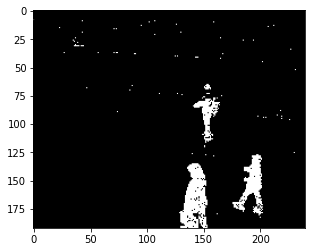

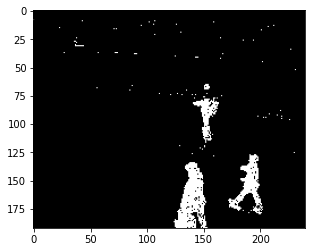

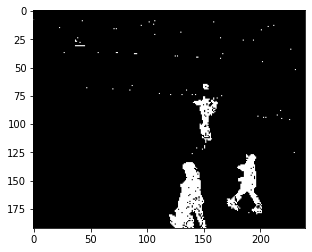

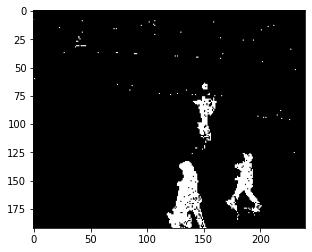

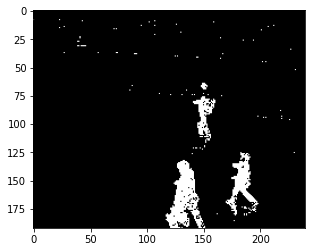

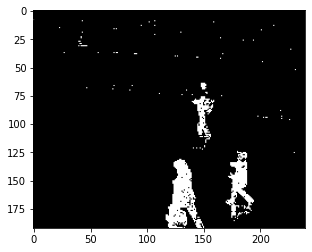

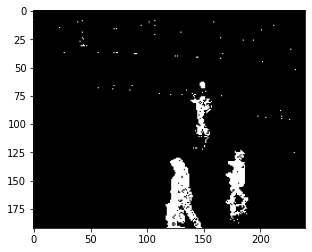

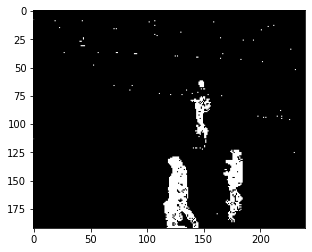

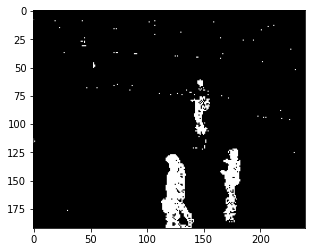

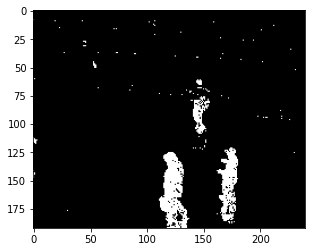

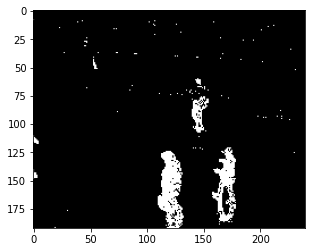

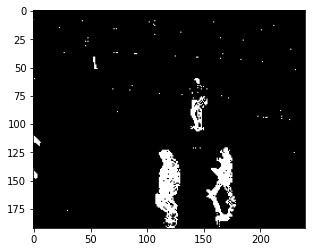

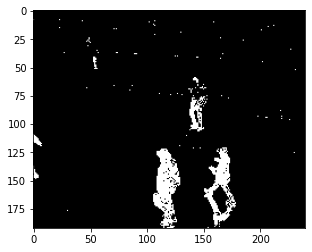

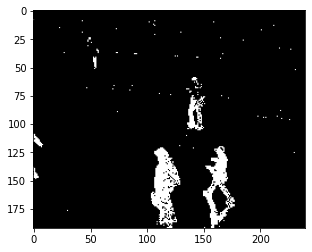

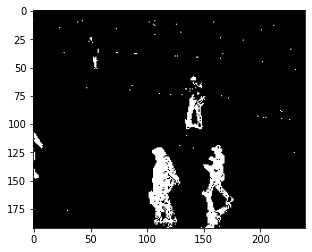

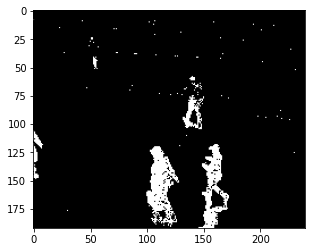

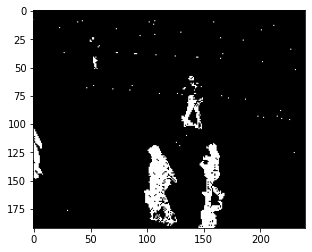

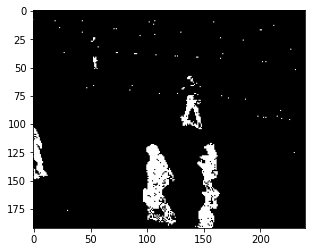

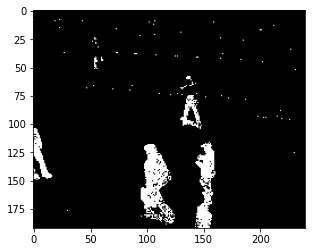

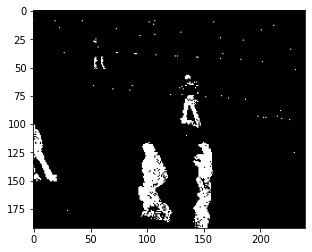

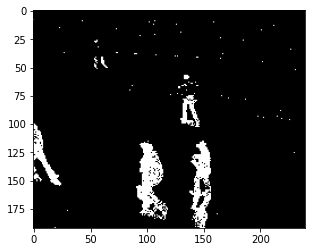

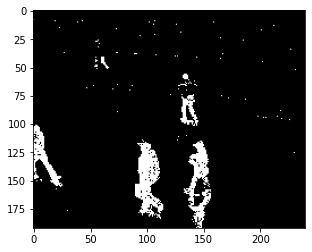

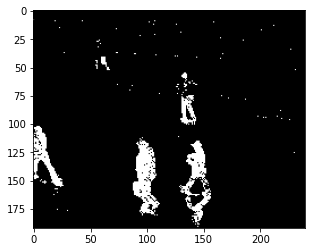

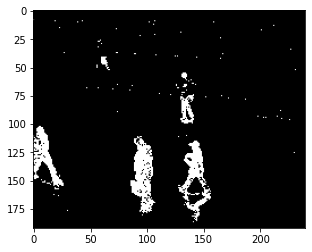

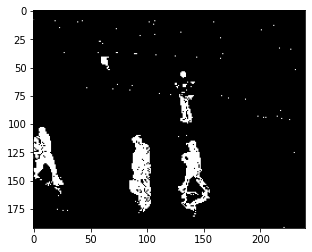

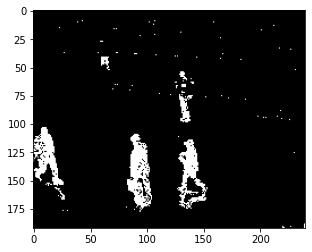

In [15]:
import cv2
resize_relation=3

img=io.imread(input_data["PETS2006"][0],as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=20
background=initBackground(img,nb_samples,gray_scale=True)
for input in input_data["PETS2006"][1:100]:
    img=io.imread(input,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    res=segmentationViBe2(img,background,0.15,2,nb_samples)
    #plt.imshow(img,cmap='gray')
    #plt.show()
    plt.imshow(res,cmap='gray', vmin=0, vmax=255)
    plt.show()


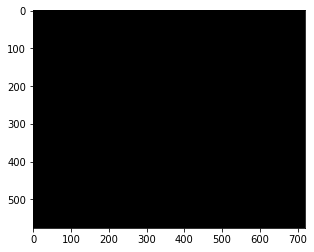

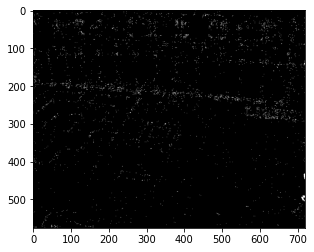

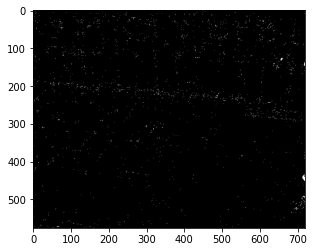

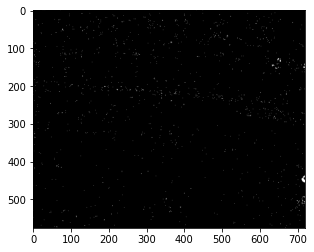

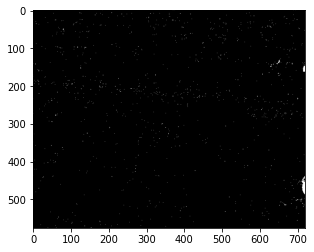

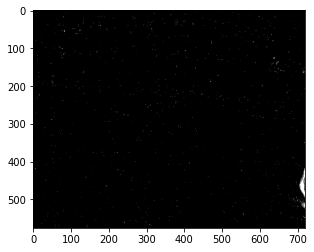

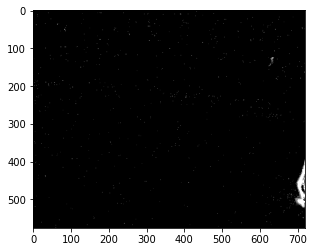

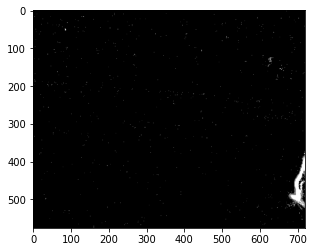

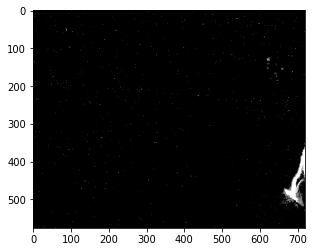

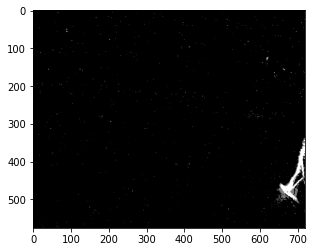

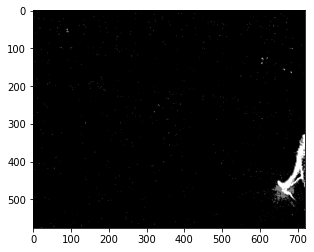

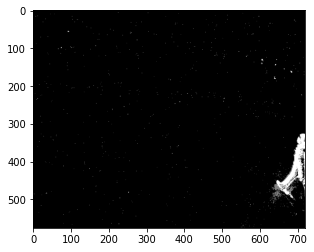

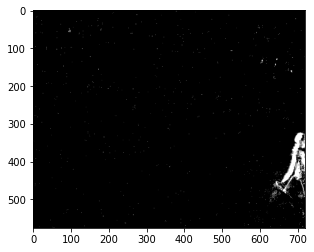

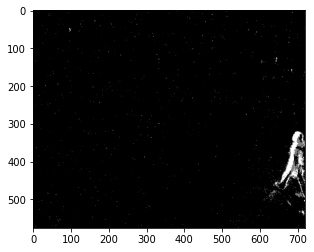

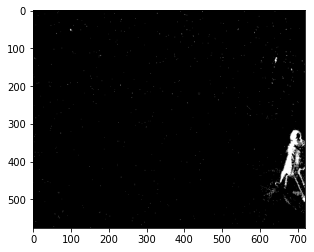

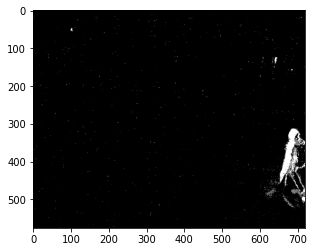

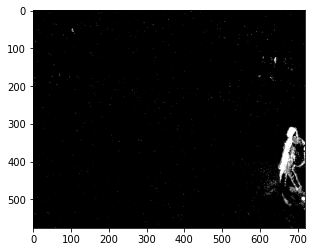

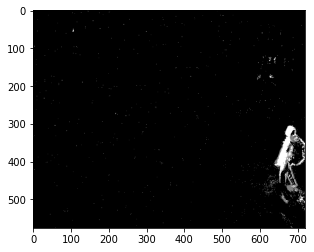

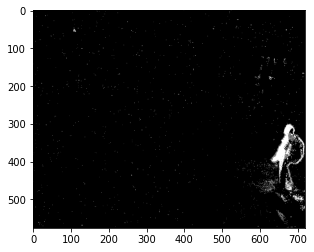

In [16]:
import cv2
MOG=cv2.createBackgroundSubtractorMOG2()
MOG.setVarThreshold(10)

resize_relation=1

img=io.imread(input_data["PETS2006"][0],as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=20
background=initBackground(img,nb_samples,gray_scale=True)
for input in input_data["PETS2006"][1:20]:
    img=io.imread(input)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    res=MOG.apply(img)
    #plt.imshow(img,cmap='gray')
    #plt.show()
    plt.imshow(res,cmap='gray')
    plt.show()


In [14]:
MOG.getVarThreshold()

16.0

In [47]:
np.unique(res, return_counts=True)

(array([  0., 255.]), array([34435, 89315], dtype=int64))